In [1]:
import mmlspark as mls

import pyspark
from pyspark.sql.functions import udf, lit, col, broadcast, avg
from pyspark.sql.types import IntegerType, StringType, DoubleType
from pyspark.ml import Transformer, Estimator, Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from functools import reduce
import numpy as np, pandas as pd, os, sys, time
from os.path import join, abspath, exists
from urllib.request import urlretrieve

spark = pyspark.sql.SparkSession.builder.appName("Snow Leopard").getOrCreate()



Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
132,application_1499328156385_0016,pyspark3,idle,Link,Link,✔


SparkSession available as 'spark'.


In [2]:
####### Download the CNTK Model #######
modelName = "ResNet50"
localModelDir = "wasb:///datasets/Models/"
d = mls.ModelDownloader(spark, localModelDir)
localModel = d.downloadByName(modelName)

print(str(localModel))

ModelSchema<name: ResNet50, dataset: ImageNet, loc: wasb:/datasets/Models/ResNet50_ImageNet.model>

In [3]:
####### Set some variables #######
rootDir = "wasb:///datasets/SnowLeopard/"
leopardDir = rootDir + "snowLeopardImages"
otherDir = rootDir + "otherImages"

imageCol = "image"
featuresCol = "features"
keyCol = "filenames"
predictionCol = "pred"
probCol = "prob"
labelCol = "label"
cameraCol = "camera"
groupCol = "group"


In [4]:
####### Read the Images #######
leopardImages = mls.ImageReader.readImages(spark, leopardDir)
otherImages = mls.ImageReader.readImages(spark, otherDir)

In [5]:
####### Load and Join the data from pendelton #######
metadataFile = rootDir + "metadata_prepped.csv"

images = leopardImages.unionAll(otherImages).cache()
nameUDF = udf(lambda s: s.split("/")[-1], StringType())
images = images.withColumn(keyCol, nameUDF(imageCol + ".path"))

metadata = spark.read.option("header", True).csv(metadataFile).cache()
metadata = metadata.withColumn(labelCol, metadata[labelCol].cast("double"))

imagesWithLabels = images.join(broadcast(metadata), keyCol).cache()

cameras = imagesWithLabels.select(cameraCol).distinct()
camerasTrain, camerasTest = cameras.randomSplit([.8, .2], seed=1)
train = imagesWithLabels.join(broadcast(camerasTrain), cameraCol).cache()
test = imagesWithLabels.join(broadcast(camerasTest), cameraCol).cache()

train.printSchema()
print("Training size: {}, testing size: {}".format(train.count(), test.count()))
print("Training partitions: {}, testing partitions: {}".format(
    train.rdd.getNumPartitions(), test.rdd.getNumPartitions()))

root
 |-- camera: string (nullable = true)
 |-- filenames: string (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- path: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- type: integer (nullable = true)
 |    |-- bytes: binary (nullable = true)
 |-- label: double (nullable = true)
 |-- img: string (nullable = true)
 |-- time: string (nullable = true)
 |-- group: string (nullable = true)

Training size: 3079, testing size: 582
Training partitions: 189, testing partitions: 189

In [6]:
def makeModel(useImageFeaturizer=True, cutOutputLayers = 1, scaleSize=60, augmentImages = True, ensembleByGroup = True,
              model=LogisticRegression()):

    stages = []

    ####### Construct the Model #######
    if augmentImages:
        ia = mls.ImageAugmenter(inputCol=imageCol, outputCol=imageCol)
        stages.append(ia)

    if useImageFeaturizer:
        feat = mls.ImageFeaturizer(
            inputCol=imageCol,
            outputCol=featuresCol,
            layerNames=localModel.layerNames,
            cutOutputLayers=cutOutputLayers)\
            .setModelLocation(spark, localModel.uri)
    else:
        it = mls.ImageTransformer() \
            .setInputCol(imageCol) \
            .setOutputCol("scaled") \
            .resize(height=scaleSize, width=scaleSize)

        ur = mls.UnrollImage() \
            .setInputCol("scaled") \
            .setOutputCol(featuresCol)

        feat = Pipeline(stages=[it, ur])

    sc1 = mls.SelectColumns(cols=[keyCol, featuresCol, labelCol, groupCol])
    featPipe = Pipeline(stages=[feat, sc1])
    tfeatPipe = mls.Timer(stage=featPipe)
    stages.append(tfeatPipe)

    rep = mls.Repartition(n=4)
    stages.append(rep)

    classifier = model\
        .setFeaturesCol(featuresCol)\
        .setLabelCol(labelCol)\
        .setPredictionCol(predictionCol)\
        .setProbabilityCol(probCol)
    sc2 = mls.SelectColumns(cols=[keyCol, predictionCol, labelCol, probCol, groupCol])
    classifierPipe = Pipeline(stages=[classifier, sc2])
    tclassifierPipe = mls.Timer(stage=classifierPipe)
    stages.append(tclassifierPipe)

    if augmentImages:
        ebk = mls.EnsembleByKey(keys=[keyCol, labelCol, groupCol], cols=[probCol], colNames=[probCol])
        stages.append(ebk)
    if ensembleByGroup:
        ebk2 = mls.EnsembleByKey(keys=[groupCol, labelCol], cols=[probCol], colNames=[probCol], collapseGroup=False)
        stages.append(ebk2)

    pipe = Pipeline(stages=stages)
    return pipe



In [7]:
def runExp(name, **kwargs):
    t0 = time.time()
    pipe = makeModel(**kwargs)
    
    ####### Fit the Model #######
    fitPipe = pipe.fit(train)
    
    ####### Save the Model
    #saveFile = "wasb:///pipelines/saved/snowLeopardPipelineNew/{}".format(name)
    #fitPipe.write().overwrite().save(saveFile)

    ####### Predict #######
    res = fitPipe.transform(test).cache().withColumnRenamed(probCol,name)
    t1 = time.time()
    print("experiment took {}s".format(t1-t0))
    return res
    

In [8]:
pred0 = runExp("L120", useImageFeaturizer=False, scaleSize=120,
                      augmentImages = False, ensembleByGroup = False)

experiment took 77.87853240966797s

In [9]:
pred1 = runExp("L60", useImageFeaturizer=False, scaleSize=60,
                      augmentImages = False, ensembleByGroup = False)

experiment took 27.495137214660645s

In [10]:
pred2 = runExp("RN1", useImageFeaturizer=True, cutOutputLayers = 1, scaleSize=60,
                      augmentImages = False, ensembleByGroup = False)

experiment took 89.84929919242859s

In [11]:
pred3 = runExp("RN2", useImageFeaturizer=True, cutOutputLayers = 2, scaleSize=60,
                      augmentImages = False, ensembleByGroup = False)

experiment took 121.87675595283508s

In [12]:
pred4 = runExp("RN2+A", useImageFeaturizer=True, cutOutputLayers = 2, scaleSize=60,
                      augmentImages = True, ensembleByGroup = False)

experiment took 237.62733364105225s

In [13]:
pred5 = runExp("RN2+A+E", useImageFeaturizer=True, cutOutputLayers = 2, scaleSize=60,
                      augmentImages = True, ensembleByGroup = True)


experiment took 246.2666299343109s

In [14]:
from functools import reduce
predictionList = [pred0,pred1,pred2,pred3,pred4,pred5]
sharedCols = [keyCol, labelCol, groupCol]

predictions = reduce(lambda d1,d2: d1.drop(predictionCol).join(broadcast(d2.drop(predictionCol)), sharedCols), predictionList)
predictions.printSchema()

# Register the predictions as a temp table for further analysis using SQL
predictions.registerTempTable("predictions")

root
 |-- filenames: string (nullable = true)
 |-- label: double (nullable = true)
 |-- group: string (nullable = true)
 |-- L120: vector (nullable = true)
 |-- L60: vector (nullable = true)
 |-- RN1: vector (nullable = true)
 |-- RN2: vector (nullable = true)
 |-- RN2+A: vector (nullable = true)
 |-- RN2+A+E: vector (nullable = true)

In [15]:
%%sql -q -o predictions
select * from predictions

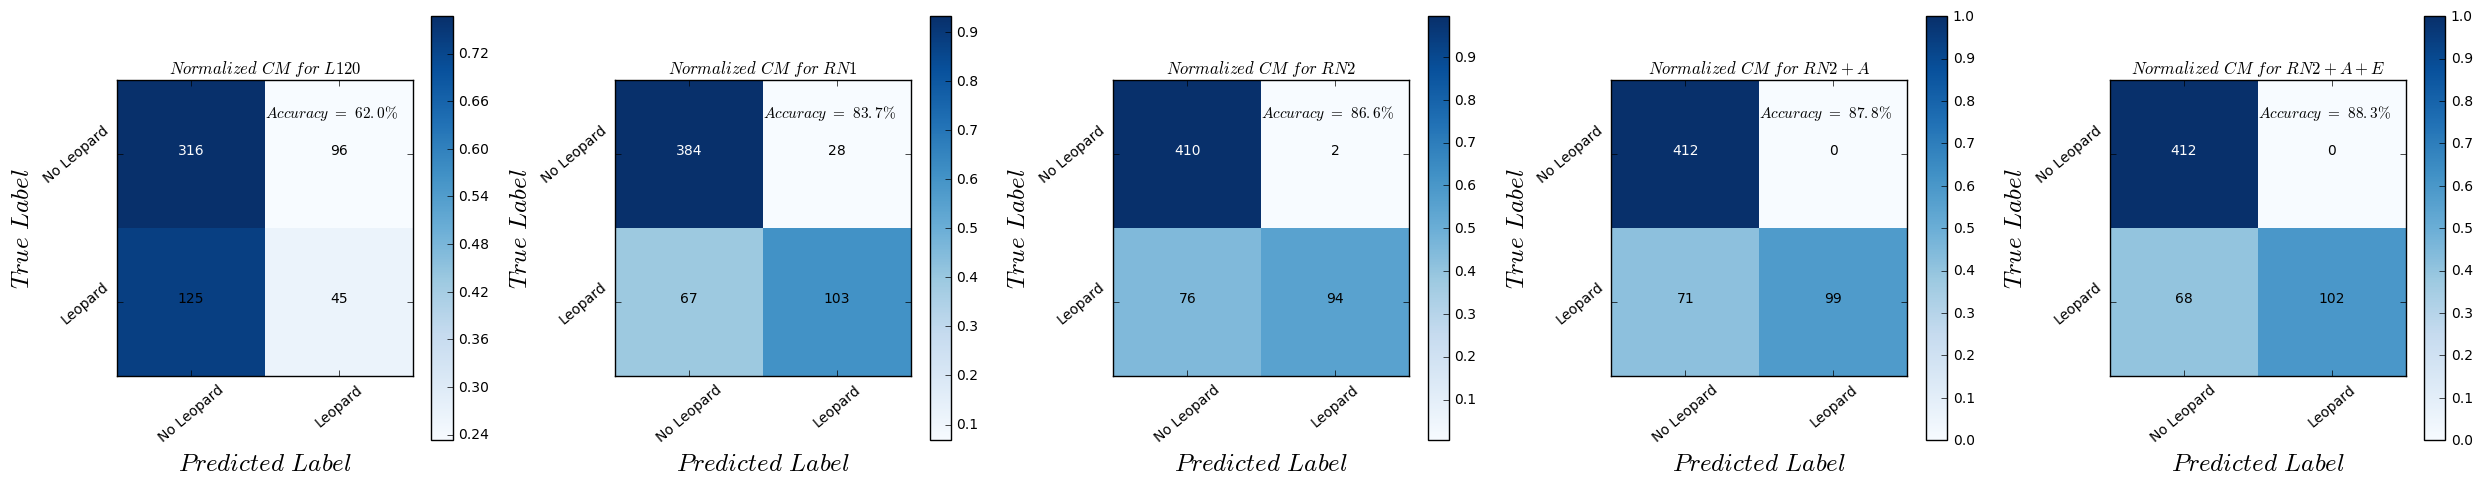

In [16]:
%%local
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

def f2i(X,thresh=.6):
    return [int(x>thresh) for x in X]

    
def plot_cm(y, y_hat, name):
    y, y_hat = f2i(y),f2i(y_hat)

    accuracy = np.mean([1. if pred==true else 0. for (pred,true) in zip(y_hat,y)])
    cm = confusion_matrix(y, y_hat)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.text(.5, -.25,"$Accuracy$ $=$ ${}\%$".format(round(accuracy*100,1)),fontsize=11)
    labels = ["No Leopard", "Leopard"]
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=40)
    plt.yticks(tick_marks, labels, rotation=40)
    plt.imshow(cmn, interpolation="nearest", cmap=plt.cm.Blues)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.colorbar()
    plt.xlabel("$Predicted$ $Label$", fontsize=18)
    plt.ylabel("$True$ $Label$", fontsize=18)
    plt.title("$Normalized$ $CM$ $for$ ${}$".format(name))


probCols = ["L120","RN1","RN2","RN2+A","RN2+A+E"]
y= np.array(predictions["label"])
y_hats =  [np.array([p['values'][1] for p in predictions[col]]) for col in probCols]


plt.figure(figsize=(5*len(probCols),5))
for i, col in enumerate(probCols):
    plt.subplot(1,len(probCols), i+1)
    plot_cm(y,y_hats[i],col)
plt.tight_layout()

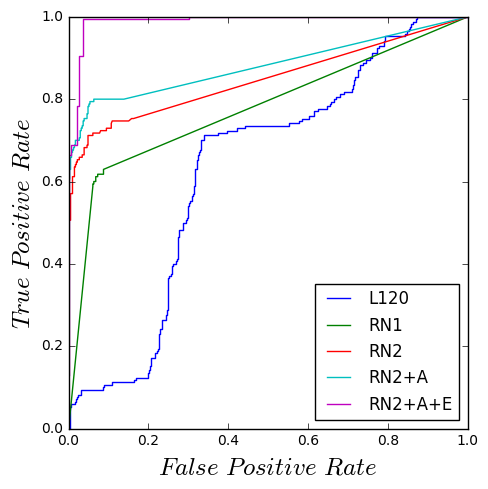

In [17]:
%%local
%matplotlib inline
from sklearn.metrics import roc_curve


def plot_roc(y, y_hat, name):
    y, y_hat = f2i(y),y_hat
    fpr, tpr, thresholds = roc_curve(y, y_hat)    
    plt.plot(fpr,tpr, label=name)

plt.figure(figsize=(5,5))
for i, col in enumerate(probCols):
    plot_roc(y,y_hats[i],col)
    
plt.xlabel("$False$ $Positive$ $Rate$",  fontsize=18)
plt.ylabel("$True$ $Positive$ $Rate$",  fontsize=18)
plt.legend(loc="lower right")
plt.tight_layout()